<p align="center"><h1 align="center">QMSS5074GR <br> Projects in Advanced Machine Learning <br>Spring 2024 <br>Assignment 2 [GROUP PROJECT]</h1>

---
<br>

#### **Your Unis** : yz4691, qg2218.
#### **Your Full names** : Yuntian Zhang, Qingxuan Guo
#### **Your AI Model Share Usernames**: yz4691, qingxuanguo
#### **Link to your Public Github repository** : https://github.com/zesiii/Advanced-ML
#### **Team member Contribution Percentages** : 50 50
---

# **STEP 1: Import packages and extract the dataset**

**Download the zip file and upload the zip file to your drive. The code assume you will upload it to your base folder in drive... however you can change the directory (just make sure to update the path accordingly)**

In [ ]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# content in your drive is now available via "/content/drive/My Drive"

# Import data and unzip files to folder
!unzip /content/drive/MyDrive/COVID-19_Radiography_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
 

In [ ]:
# Load libraries and then download data
import random
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile
import pickle
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

# **STEP 2: Prepare the dataset**

In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']


# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)


print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-1224.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-9.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-73.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1700.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-159.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3514.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-667.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3173.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2470.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1223.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3201.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3233.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1689.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1027.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-909.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-7

In [ ]:
#Reduce number of images to first 1345 for each category
fnames[0] = fnames[0][0:1344]
fnames[1] = fnames[1][0:1344]
fnames[2] = fnames[2][0:1344]

In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image



def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [ ]:
#Import image files iteratively and preprocess them into array of correctly structured data


# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]


# Iteratively import and preprocess data using map function


# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor, image_filepaths))


# Object needs to be an array rather than a list for Keras (map returns to list object)
X = np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [ ]:
print(len(X) )          # same number of elements as filenames

print(X.shape )         # dimensions now 192,192,3 for all images

print(X.min().round() ) # min value of every image is zero

print(X.max() )         # max value of every image is one

4032
(4032, 192, 192, 3)
-0.0
1.0


In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat


# Recall that we have five folders with the following number of images in each folder
#...corresponding to each flower type
print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))


#combine into single list of y labels
y_labels = covid + normal + pneumonia


#check length, same as X above
print(len(y_labels))


# Need to one hot encode for Keras.  Let's use Pandas
import pandas as pd
y = pd.get_dummies(y_labels)


display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


# STEP 3: Visualizations 
Visualize images of each category. 

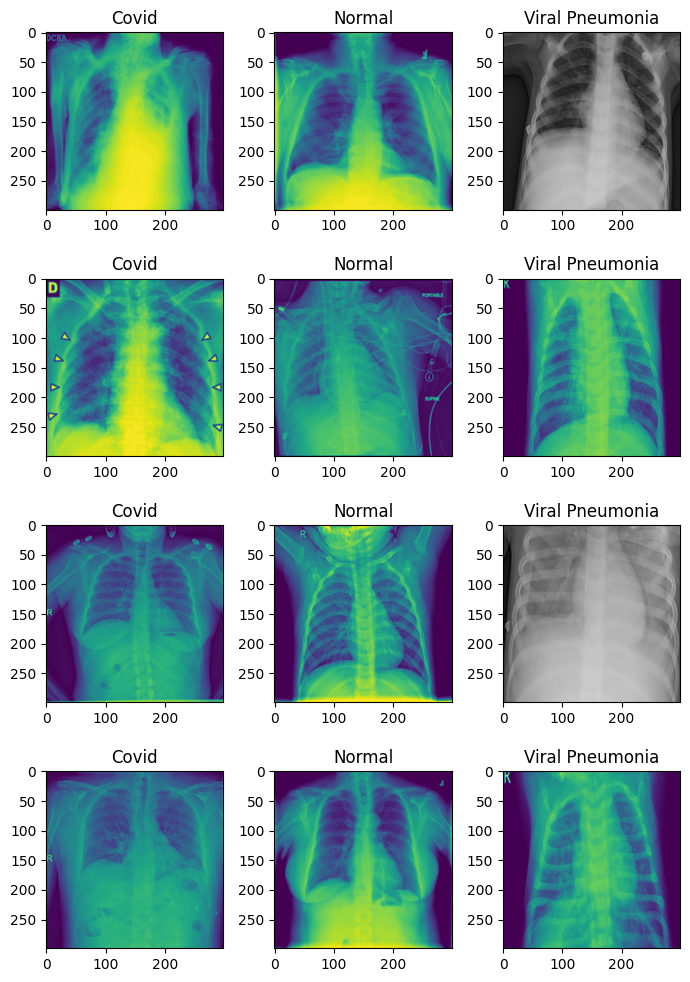

In [ ]:
fig,ax=plt.subplots(4,3)
fig.set_size_inches(7,10)
diagnose_list = ['Covid','Normal','Viral Pneumonia']
for j in range(3):
  image_chosen = random.sample(fnames[j],4)
  for i in range(4):
    ax[i,j].imshow(Image.open(image_chosen[i]))
    ax[i,j].set_title(diagnose_list[j])

plt.tight_layout()

# STEP 4: Analyzing and Augmenting Dataset


## Analysis - Edge Detection

In [ ]:
import cv2
edge_detected_images = []
for img_data in X:
    # Convert the image to grayscale
    img_data2 = (img_data*255).astype(np.uint8)
    gray_img = cv2.cvtColor(img_data2, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(gray_img, threshold1=100, threshold2=200)  # Adjust thresholds as needed

    # Append the edge-detected image to the list
    edge_detected_images.append(edges)

# Convert the list of edge-detected images to a NumPy array
edge_detected_images_arr = np.array(edge_detected_images)

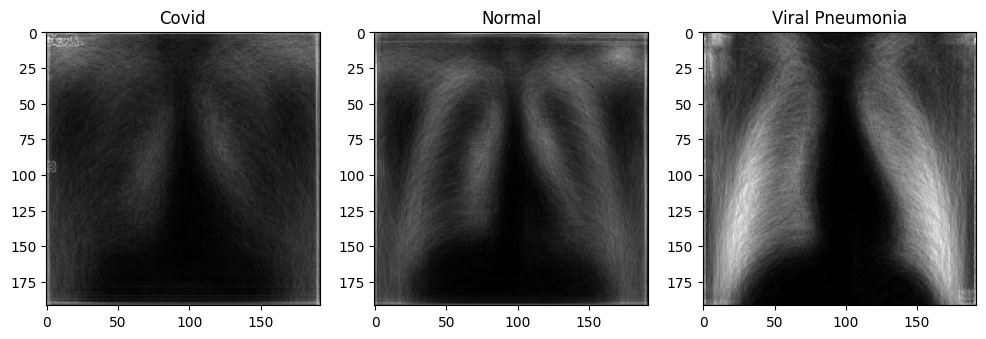

In [ ]:
covid_edge = edge_detected_images_arr[0:1344]
normal_edge = edge_detected_images_arr[1344:2688]
pne_edge = edge_detected_images_arr[2688:]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i in range(3):
  edge_maps_array = edge_detected_images_arr[1344*i:1344*(i+1)]
  composite_edge_map = np.mean(edge_maps_array, axis=0)
  composite_edge_map = (composite_edge_map - np.min(composite_edge_map)) / (np.max(composite_edge_map) - np.min(composite_edge_map)) * 255
  axes[i].imshow(composite_edge_map, cmap='gray')
  axes[i].set_title(diagnose_list[i])

We did edge detection of each image in the dataset and combined the edge detection results grouped by the 3 categories. The result edge maps are shown above.

Due to the different scale of each X-ray image (some are close-ups on lung, some include part of the arms, etc.), the edge maps are not definitive. But we can see that viral pneumonia has more white shades in lung section and covid has least.

## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import pandas as pd
data = pd.DataFrame({'X': image_filepaths, 'y': y_labels})
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = []
augmented_labels = []
for index, row in data.iterrows():
    img = load_img(row['X'], target_size=(192, 192))  # Load the image

    img_array = img_to_array(img)  # Convert to numpy array
    img_array = img_array / 255.0  # Scale pixel values to [0, 1]
    img_array = img_array.reshape((1,) + img_array.shape)
    # img_array = img_to_array(img)  # Convert to numpy array
    # img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for the datagen.flow() method

    # Apply the augmentations
    i = 0
    for batch in datagen.flow(img_array, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(row['y'])
        i += 1
        if i >= 1:  # Generate 'n' augmented images per original image
            break

In [ ]:
X_augmented_images = np.concatenate((np.stack(augmented_images), X), axis=0)
del(X)
del(augmented_images)

In [ ]:
del(preprocessed_image_data)
y_augmented_labels = pd.concat([pd.get_dummies(augmented_labels), y])
del(y)
del(augmented_labels)

### Preprocessing strategy:
The preprocessor function we used converted input images to RGB format and scaled the pixel values of an image to 0-1. Therefore, their matrices are in the right size for Keras input.

Using preprocessor, the input images can be correctly processed by Keras.
### Data Augmentation:

Through resizing, rotating and flipping images, more input data are created. The new images are essentially the same to human eyes but different to machines. Through data augmentation, we can have a much larger dataset and hence have a more robust prediction model.


# **STEP 5: Splitting Dataset**


In [ ]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_augmented_images, y_augmented_labels, stratify = y_augmented_labels, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((2581, 192, 192, 3), (2581, 3))

In [ ]:
del(X_augmented_images)
del(y_augmented_labels)

In [ ]:
with open('/content/drive/MyDrive/X_train.pkl', 'wb') as file:
  pickle.dump(X_train, file)
with open('/content/drive/MyDrive/y_train.pkl', 'wb') as file:
  pickle.dump(y_train, file)
with open('/content/drive/MyDrive/X_test.pkl', 'wb') as file:
  pickle.dump(X_test, file)
with open('/content/drive/MyDrive/y_test.pkl', 'wb') as file:
  pickle.dump(y_test, file)

In [ ]:
# reload train_split data
import pickle
with open('/content/drive/MyDrive/X_train.pkl', 'rb') as file:
  X_train = pickle.load(file)
with open('/content/drive/MyDrive/y_train.pkl', 'rb') as file:
  y_train = pickle.load(file)
with open('/content/drive/MyDrive/X_test.pkl', 'rb') as file:
  X_test = pickle.load(file)
with open('/content/drive/MyDrive/y_test.pkl', 'rb') as file:
  y_test = pickle.load(file)

In [ ]:
X_test.shape, y_test.shape

((2581, 192, 192, 3), (2581, 3))

# STEP 6: Model Training and parameter tuning 

# **STEP 6(a): Custom CNN based models**

## CNN model 1

In [ ]:
import tensorflow as tf
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Flatten
from keras.optimizers import Adam

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)
    Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
		BatchNormalization(),
    Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
		Dropout(rate=0.3),

    Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
		BatchNormalization(),
    Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
		Dropout(rate=0.3),

    Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
		BatchNormalization(),
    Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
		Dropout(rate=0.3),

    Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
		BatchNormalization(),
    Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
		Dropout(rate=0.4),

    Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
		BatchNormalization(),
    Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
		Dropout(rate=0.4),
    Flatten(),

		Dense(256, activation='relu'),
    # classifying into 3 categories
    Dense(3, activation='softmax')
  ])

  mc = ModelCheckpoint('best_model_cnn1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  red_lr= ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer=Adam(lr=0.1),
    loss= 'categorical_crossentropy',
    metrics=['accuracy']
    )

  # Fitting the CNN to the Training set
  history = model.fit(X_train, y_train,
						epochs=40, verbose=1, validation_split=.2, callbacks=[mc, red_lr])

Epoch 1/50
  3/138 [..............................] - ETA: 19:24 - loss: 48.8693 - accuracy: 0.3333

KeyboardInterrupt: 

In [ ]:
# save the best model
pd.DataFrame(history.history).to_csv('training_history_cnn1.csv')
model.save("best_model_cnn1.h5", save_format="h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## CNN model 2

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(192, 192, 3)))

  # 1st conv block
  model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
  # 2nd conv block
  model.add(Conv2D(64, (5, 5), activation='relu', strides=(2, 2), padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
  model.add(BatchNormalization())
  # 3rd conv block
  model.add(Conv2D(128, (3, 3), activation='relu', strides=(2, 2), padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
  model.add(BatchNormalization())
  # ANN block
  model.add(Flatten())
  model.add(Dense(units=64, activation='relu'))
  model.add(Dense(units=32, activation='relu'))
  model.add(Dropout(0.25))
  # output layer
  model.add(Dense(units=3, activation='softmax'))

  # compile model
  model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

  mc = ModelCheckpoint('best_model_cnn2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  red_lr= ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer=Adam(lr=0.1),
    loss= 'categorical_crossentropy',
    metrics=['accuracy']
    )

  history = model.fit(X_train, y_train,
						epochs=50, verbose=1, validation_split=.2, callbacks=[mc, red_lr])





Epoch 1/50
138/138 [==============================] - ETA: 0s - loss: 1.0294 - accuracy: 0.4982
Epoch 1: val_accuracy improved from -inf to 0.46126, saving model to best_model_cnn2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


138/138 [==============================] - 24s 98ms/step - loss: 1.0294 - accuracy: 0.4982 - val_loss: 0.9581 - val_accuracy: 0.4613 - lr: 0.0010
Epoch 2/50
137/138 [============================>.] - ETA: 0s - loss: 0.7914 - accuracy: 0.5604
Epoch 2: val_accuracy improved from 0.46126 to 0.54512, saving model to best_model_cnn2.h5


138/138 [==============================] - 11s 81ms/step - loss: 0.7915 - accuracy: 0.5604 - val_loss: 0.8464 - val_accuracy: 0.5451 - lr: 0.0010
Epoch 3/50
137/138 [============================>.] - ETA: 0s - loss: 0.7331 - accuracy: 0.5890
Epoch 3: val_accuracy improved from 0.54512 to 0.55150, saving model to best_model_cnn2.h5


138/138 [==============================] - 11s 78ms/step - loss: 0.7330 - accuracy: 0.5889 - val_loss: 0.8110 - val_accuracy: 0.5515 - lr: 0.0010
Epoch 4/50
137/138 [============================>.] - ETA: 0s - loss: 0.6969 - accuracy: 0.6166
Epoch 4: val_accuracy improved from 0.55150 to 0.57156, saving model to best_model_cnn2.h5


138/138 [==============================] - 11s 81ms/step - loss: 0.6969 - accuracy: 0.6165 - val_loss: 0.7735 - val_accuracy: 0.5716 - lr: 0.0010
Epoch 5/50
137/138 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6195
Epoch 5: val_accuracy improved from 0.57156 to 0.58797, saving model to best_model_cnn2.h5


138/138 [==============================] - 11s 80ms/step - loss: 0.6644 - accuracy: 0.6195 - val_loss: 0.7838 - val_accuracy: 0.5880 - lr: 0.0010
Epoch 6/50
137/138 [============================>.] - ETA: 0s - loss: 0.6494 - accuracy: 0.6245
Epoch 6: val_accuracy did not improve from 0.58797


138/138 [==============================] - 11s 83ms/step - loss: 0.6493 - accuracy: 0.6245 - val_loss: 1.2124 - val_accuracy: 0.5059 - lr: 0.0010
Epoch 7/50
137/138 [============================>.] - ETA: 0s - loss: 0.6326 - accuracy: 0.6350
Epoch 7: val_accuracy improved from 0.58797 to 0.62625, saving model to best_model_cnn2.h5


138/138 [==============================] - 11s 83ms/step - loss: 0.6324 - accuracy: 0.6352 - val_loss: 0.7066 - val_accuracy: 0.6263 - lr: 0.0010
Epoch 8/50
137/138 [============================>.] - ETA: 0s - loss: 0.6319 - accuracy: 0.6403
Epoch 8: val_accuracy did not improve from 0.62625


138/138 [==============================] - 11s 79ms/step - loss: 0.6319 - accuracy: 0.6402 - val_loss: 1.1675 - val_accuracy: 0.5160 - lr: 0.0010
Epoch 9/50
137/138 [============================>.] - ETA: 0s - loss: 0.6176 - accuracy: 0.6455
Epoch 9: val_accuracy did not improve from 0.62625


138/138 [==============================] - 11s 80ms/step - loss: 0.6175 - accuracy: 0.6457 - val_loss: 0.7026 - val_accuracy: 0.6089 - lr: 0.0010
Epoch 10/50
137/138 [============================>.] - ETA: 0s - loss: 0.6061 - accuracy: 0.6496
Epoch 10: val_accuracy did not improve from 0.62625


138/138 [==============================] - 11s 81ms/step - loss: 0.6086 - accuracy: 0.6493 - val_loss: 0.7447 - val_accuracy: 0.6053 - lr: 0.0010
Epoch 11/50
137/138 [============================>.] - ETA: 0s - loss: 0.6028 - accuracy: 0.6540
Epoch 11: val_accuracy did not improve from 0.62625


138/138 [==============================] - 11s 81ms/step - loss: 0.6028 - accuracy: 0.6539 - val_loss: 1.0028 - val_accuracy: 0.5488 - lr: 0.0010
Epoch 12/50
137/138 [============================>.] - ETA: 0s - loss: 0.5903 - accuracy: 0.6558
Epoch 12: val_accuracy did not improve from 0.62625


138/138 [==============================] - 12s 85ms/step - loss: 0.5903 - accuracy: 0.6560 - val_loss: 0.8729 - val_accuracy: 0.5561 - lr: 0.0010
Epoch 13/50
137/138 [============================>.] - ETA: 0s - loss: 0.5822 - accuracy: 0.6599
Epoch 13: val_accuracy did not improve from 0.62625


138/138 [==============================] - 11s 82ms/step - loss: 0.5819 - accuracy: 0.6601 - val_loss: 0.7254 - val_accuracy: 0.6253 - lr: 0.0010
Epoch 14/50
137/138 [============================>.] - ETA: 0s - loss: 0.5786 - accuracy: 0.6624
Epoch 14: val_accuracy did not improve from 0.62625


138/138 [==============================] - 11s 82ms/step - loss: 0.5786 - accuracy: 0.6623 - val_loss: 1.0523 - val_accuracy: 0.5488 - lr: 0.0010
Epoch 15/50
137/138 [============================>.] - ETA: 0s - loss: 0.6108 - accuracy: 0.6524
Epoch 15: val_accuracy did not improve from 0.62625


138/138 [==============================] - 12s 85ms/step - loss: 0.6108 - accuracy: 0.6525 - val_loss: 0.8384 - val_accuracy: 0.5916 - lr: 0.0010
Epoch 16/50
137/138 [============================>.] - ETA: 0s - loss: 0.5874 - accuracy: 0.6576
Epoch 16: val_accuracy did not improve from 0.62625


138/138 [==============================] - 12s 85ms/step - loss: 0.5878 - accuracy: 0.6573 - val_loss: 0.6931 - val_accuracy: 0.6244 - lr: 0.0010
Epoch 17/50
137/138 [============================>.] - ETA: 0s - loss: 0.5781 - accuracy: 0.6610
Epoch 17: val_accuracy did not improve from 0.62625


138/138 [==============================] - 12s 85ms/step - loss: 0.5781 - accuracy: 0.6610 - val_loss: 0.7280 - val_accuracy: 0.6226 - lr: 0.0010
Epoch 18/50
137/138 [============================>.] - ETA: 0s - loss: 0.5723 - accuracy: 0.6645
Epoch 18: val_accuracy did not improve from 0.62625


138/138 [==============================] - 11s 81ms/step - loss: 0.5723 - accuracy: 0.6644 - val_loss: 0.7639 - val_accuracy: 0.6226 - lr: 0.0010
Epoch 19/50
137/138 [============================>.] - ETA: 0s - loss: 0.5630 - accuracy: 0.6695
Epoch 19: val_accuracy did not improve from 0.62625


138/138 [==============================] - 12s 84ms/step - loss: 0.5630 - accuracy: 0.6694 - val_loss: 0.7598 - val_accuracy: 0.6199 - lr: 0.0010
Epoch 20/50
137/138 [============================>.] - ETA: 0s - loss: 0.5771 - accuracy: 0.6651
Epoch 20: val_accuracy did not improve from 0.62625


138/138 [==============================] - 11s 81ms/step - loss: 0.5790 - accuracy: 0.6648 - val_loss: 0.7723 - val_accuracy: 0.6135 - lr: 0.0010
Epoch 21/50
137/138 [============================>.] - ETA: 0s - loss: 0.5832 - accuracy: 0.6604
Epoch 21: val_accuracy improved from 0.62625 to 0.63537, saving model to best_model_cnn2.h5


138/138 [==============================] - 12s 86ms/step - loss: 0.5829 - accuracy: 0.6605 - val_loss: 1.1489 - val_accuracy: 0.6354 - lr: 0.0010
Epoch 22/50
137/138 [============================>.] - ETA: 0s - loss: 0.5719 - accuracy: 0.6647
Epoch 22: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 81ms/step - loss: 0.5716 - accuracy: 0.6648 - val_loss: 0.7897 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 23/50
137/138 [============================>.] - ETA: 0s - loss: 0.5557 - accuracy: 0.6702
Epoch 23: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 81ms/step - loss: 0.5557 - accuracy: 0.6701 - val_loss: 0.7706 - val_accuracy: 0.6272 - lr: 0.0010
Epoch 24/50
137/138 [============================>.] - ETA: 0s - loss: 0.5537 - accuracy: 0.6708
Epoch 24: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 81ms/step - loss: 0.5535 - accuracy: 0.6710 - val_loss: 0.8356 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 25/50
137/138 [============================>.] - ETA: 0s - loss: 0.5552 - accuracy: 0.6695
Epoch 25: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 81ms/step - loss: 0.5560 - accuracy: 0.6692 - val_loss: 0.7766 - val_accuracy: 0.6208 - lr: 0.0010
Epoch 26/50
137/138 [============================>.] - ETA: 0s - loss: 0.5670 - accuracy: 0.6656
Epoch 26: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 81ms/step - loss: 0.5679 - accuracy: 0.6655 - val_loss: 0.8265 - val_accuracy: 0.5980 - lr: 0.0010
Epoch 27/50
137/138 [============================>.] - ETA: 0s - loss: 0.6655 - accuracy: 0.6341
Epoch 27: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 80ms/step - loss: 0.6654 - accuracy: 0.6341 - val_loss: 1.9619 - val_accuracy: 0.4813 - lr: 0.0010
Epoch 28/50
137/138 [============================>.] - ETA: 0s - loss: 0.6016 - accuracy: 0.6569
Epoch 28: val_accuracy did not improve from 0.63537


138/138 [==============================] - 12s 84ms/step - loss: 0.6016 - accuracy: 0.6569 - val_loss: 1.1272 - val_accuracy: 0.5387 - lr: 0.0010
Epoch 29/50
137/138 [============================>.] - ETA: 0s - loss: 0.5711 - accuracy: 0.6629
Epoch 29: val_accuracy did not improve from 0.63537


138/138 [==============================] - 12s 84ms/step - loss: 0.5711 - accuracy: 0.6630 - val_loss: 0.8102 - val_accuracy: 0.6162 - lr: 0.0010
Epoch 30/50
137/138 [============================>.] - ETA: 0s - loss: 0.5575 - accuracy: 0.6706
Epoch 30: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 80ms/step - loss: 0.5576 - accuracy: 0.6708 - val_loss: 0.8304 - val_accuracy: 0.6226 - lr: 0.0010
Epoch 31/50
137/138 [============================>.] - ETA: 0s - loss: 0.5695 - accuracy: 0.6661
Epoch 31: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 80ms/step - loss: 0.5695 - accuracy: 0.6662 - val_loss: 0.7615 - val_accuracy: 0.6199 - lr: 0.0010
Epoch 32/50
137/138 [============================>.] - ETA: 0s - loss: 0.5633 - accuracy: 0.6690
Epoch 32: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 81ms/step - loss: 0.5633 - accuracy: 0.6689 - val_loss: 0.7844 - val_accuracy: 0.6226 - lr: 0.0010
Epoch 33/50
137/138 [============================>.] - ETA: 0s - loss: 0.5530 - accuracy: 0.6702
Epoch 33: val_accuracy did not improve from 0.63537


138/138 [==============================] - 12s 84ms/step - loss: 0.5527 - accuracy: 0.6703 - val_loss: 0.7794 - val_accuracy: 0.6253 - lr: 0.0010
Epoch 34/50
137/138 [============================>.] - ETA: 0s - loss: 0.5528 - accuracy: 0.6713
Epoch 34: val_accuracy did not improve from 0.63537


138/138 [==============================] - 12s 84ms/step - loss: 0.5528 - accuracy: 0.6712 - val_loss: 0.7747 - val_accuracy: 0.6226 - lr: 0.0010
Epoch 35/50
137/138 [============================>.] - ETA: 0s - loss: 0.5513 - accuracy: 0.6711
Epoch 35: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 80ms/step - loss: 0.5513 - accuracy: 0.6710 - val_loss: 0.8091 - val_accuracy: 0.6290 - lr: 0.0010
Epoch 36/50
137/138 [============================>.] - ETA: 0s - loss: 0.5510 - accuracy: 0.6713
Epoch 36: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 80ms/step - loss: 0.5510 - accuracy: 0.6712 - val_loss: 0.9641 - val_accuracy: 0.6180 - lr: 0.0010
Epoch 37/50
137/138 [============================>.] - ETA: 0s - loss: 0.5547 - accuracy: 0.6686
Epoch 37: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 80ms/step - loss: 0.5547 - accuracy: 0.6687 - val_loss: 0.9746 - val_accuracy: 0.6345 - lr: 0.0010
Epoch 38/50
137/138 [============================>.] - ETA: 0s - loss: 0.5506 - accuracy: 0.6715
Epoch 38: val_accuracy did not improve from 0.63537


138/138 [==============================] - 12s 85ms/step - loss: 0.5506 - accuracy: 0.6717 - val_loss: 0.8675 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 39/50
137/138 [============================>.] - ETA: 0s - loss: 0.5504 - accuracy: 0.6718
Epoch 39: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 81ms/step - loss: 0.5504 - accuracy: 0.6717 - val_loss: 0.8671 - val_accuracy: 0.6281 - lr: 0.0010
Epoch 40/50
137/138 [============================>.] - ETA: 0s - loss: 0.5621 - accuracy: 0.6681
Epoch 40: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 80ms/step - loss: 0.5619 - accuracy: 0.6683 - val_loss: 1.0832 - val_accuracy: 0.5916 - lr: 0.0010
Epoch 41/50
137/138 [============================>.] - ETA: 0s - loss: 0.6024 - accuracy: 0.6569
Epoch 41: val_accuracy did not improve from 0.63537


138/138 [==============================] - 12s 84ms/step - loss: 0.6025 - accuracy: 0.6569 - val_loss: 0.8164 - val_accuracy: 0.6126 - lr: 0.0010
Epoch 42/50
137/138 [============================>.] - ETA: 0s - loss: 0.5696 - accuracy: 0.6672
Epoch 42: val_accuracy did not improve from 0.63537


138/138 [==============================] - 12s 84ms/step - loss: 0.5693 - accuracy: 0.6674 - val_loss: 0.8417 - val_accuracy: 0.6126 - lr: 0.0010
Epoch 43/50
137/138 [============================>.] - ETA: 0s - loss: 0.5554 - accuracy: 0.6706
Epoch 43: val_accuracy did not improve from 0.63537


138/138 [==============================] - 12s 84ms/step - loss: 0.5554 - accuracy: 0.6705 - val_loss: 0.8165 - val_accuracy: 0.6208 - lr: 0.0010
Epoch 44/50
137/138 [============================>.] - ETA: 0s - loss: 0.5533 - accuracy: 0.6702
Epoch 44: val_accuracy did not improve from 0.63537


138/138 [==============================] - 12s 85ms/step - loss: 0.5533 - accuracy: 0.6701 - val_loss: 0.7984 - val_accuracy: 0.6326 - lr: 0.0010
Epoch 45/50
137/138 [============================>.] - ETA: 0s - loss: 0.5539 - accuracy: 0.6695
Epoch 45: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 80ms/step - loss: 0.5539 - accuracy: 0.6696 - val_loss: 0.8898 - val_accuracy: 0.6226 - lr: 0.0010
Epoch 46/50
137/138 [============================>.] - ETA: 0s - loss: 0.5587 - accuracy: 0.6686
Epoch 46: val_accuracy did not improve from 0.63537


138/138 [==============================] - 12s 85ms/step - loss: 0.5588 - accuracy: 0.6685 - val_loss: 0.8243 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 47/50
137/138 [============================>.] - ETA: 0s - loss: 0.5778 - accuracy: 0.6640
Epoch 47: val_accuracy did not improve from 0.63537


138/138 [==============================] - 12s 85ms/step - loss: 0.5775 - accuracy: 0.6642 - val_loss: 1.0172 - val_accuracy: 0.5752 - lr: 0.0010
Epoch 48/50
137/138 [============================>.] - ETA: 0s - loss: 0.5749 - accuracy: 0.6640
Epoch 48: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 80ms/step - loss: 0.5749 - accuracy: 0.6639 - val_loss: 0.8156 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 49/50
137/138 [============================>.] - ETA: 0s - loss: 0.5544 - accuracy: 0.6708
Epoch 49: val_accuracy did not improve from 0.63537


138/138 [==============================] - 12s 85ms/step - loss: 0.5544 - accuracy: 0.6710 - val_loss: 0.7684 - val_accuracy: 0.6208 - lr: 0.0010
Epoch 50/50
137/138 [============================>.] - ETA: 0s - loss: 0.5522 - accuracy: 0.6708
Epoch 50: val_accuracy did not improve from 0.63537


138/138 [==============================] - 11s 80ms/step - loss: 0.5520 - accuracy: 0.6710 - val_loss: 0.8069 - val_accuracy: 0.6171 - lr: 0.0010


NameError: name 'pd' is not defined

In [ ]:
import pandas as pd
pd.DataFrame(history.history).to_csv('training_history_cnn2.csv')
model.save("best_model_cnn2.h5", save_format="h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1. *What motivated your specific architectural design choices when implementing your custom CNNs? Discuss the reasoning behind the number of layers, types of layers (convolutional, pooling, fully connected, etc.), and their configurations.*

Besides the basic CNN and Dense layers, we also added some techniques learnt at class such as Dropout, BatchNormalization.

For both models, batchnormalization improves the training stability and convergence speed of neural network by normalizing the input of each layer across the mini-batch during training, so we add this layer after each chunk of Conv2D layers.

For both models, we don't want to add too many Dropout layers because that would slow down the convergence, so we added a few after some Conv2D layers.

For the second model, Max pooling can downsample feature maps, reducing their spatial dimensions, so we add it after convolutional layers to reduce dimensions.

2. *Which regularization techniques and callbacks did you implement to prevent overfitting? Explain how you chose where to apply these techniques and their effectiveness.*

  * BatchNormalization in both models can prevent overfitting through regularization.
  * We use Dropout to disconnect some nodes from the network to get a more balanced and robust network. Dropout is a very effective solution to overfitting.
  * We also prevent overfitting by manually checking the testing loss and validation loss, and control the number of epochs prior to overfitting happens.

3. *Describe your approach to hyperparameter tuning. How did you select the values for learning rate, batch size, and number of epochs? Discuss any strategies you used to find the optimal hyperparameters.*

We set up a monitor to prevent stagnated improvement in result. If the learning rate hasn't improved in 2-3 epochs, we will divide it by 10 to reduce stride size and better look for local minimums.

For epoch number, we observe the training history of each model and set it to an appropriate number where the validation accuracy can reach its maximum and keep constant.

4. *Which loss function and optimizer did you choose for training your CNN, and why? How do these choices impact the convergence and accuracy of your model?*

We chose Adam optimizer because it's not robust and applicable to different data. It is also common practice to use Adam in traning NN. I would say it help improve the convergance and accuracy, since Adam uses momentum to speed up convergence.

5. *Reflect on a significant challenge you encountered during the implementation of your CNN. How did you overcome this challenge, and what did you learn from it?*

The fitting process of CNN without GPU is too slow that it's impossible to test and improve the model based the outcome. Since each account only have 1.5h a day of free Colab GPU, we each used our personal google account besides lionmail account to have more time to test models.

I think the lesson here is that GPU is important to data science job and the development of AWS and Azure allowed for more convenient use of cloud GPU for business.

In [ ]:
# Your answers and discussion here

# **STEP 6(b): Transfer Learning models**

You will use a minimum of 2 Pre-trained models and Fine-tune them on our dataset. Take careful choices about which models you get from the internet. Cite their usage properly within this notebook, and in the Github repo (instructions in last section).

## Transfer Model 1 -- EfficientNetB6

In [ ]:
from keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

with tf.device('/device:GPU:0'):
  base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = (192,192,3))
  #freeze the model
  base_model.trainable = False
  for layer in base_model.layers[-20:]:
    layer.trainable = True

  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(3, activation='softmax'))

  # Compile the model
  model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  mc = ModelCheckpoint('best_model_enet.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  # Train the model
  history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[mc])


In [ ]:
# save the best model
pd.DataFrame(history.history).to_csv('training_history_enet.csv')
model.save('best_model_enet.h5', save_format = 'h5')

## Transfer Model 2 - ResNet50

In [ ]:
from keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
with tf.device('/device:GPU:0'):
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape = (192,192,3))
  #freeze the model
  base_model.trainable = False
  for layer in base_model.layers[-5:]:
    layer.trainable = True
  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(3, activation='softmax'))

  mc = ModelCheckpoint('best_model_enet.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  # Compile the model
  model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  # Train the model
  history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), callbacks = [mc])

In [ ]:
import pandas as pd
pd.DataFrame(history.history).to_csv('training_history_resnet50.csv')
model.save('best_model_resnet50.h5', save_format = 'h5')

## Transfer Model 3 - VGG16

In [ ]:
from keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

with tf.device('/device:GPU:0'):
  base_model = VGG16(weights='imagenet', include_top=False, input_shape = (192,192,3))
  #freeze the model
  base_model.trainable = False
  for layer in base_model.layers[-5:]:
    layer.trainable = True

  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  # Compile the model
  model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  # Train the model
  history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/20
86/86 [==============================] - 28s 248ms/step - loss: 0.7346 - accuracy: 0.7158 - val_loss: 0.6027 - val_accuracy: 0.7583
Epoch 2/20
86/86 [==============================] - 13s 151ms/step - loss: 0.4772 - accuracy: 0.8227 - val_loss: 0.4628 - val_accuracy: 0.8033
Epoch 3/20
86/86 [==============================] - 14s 162ms/step - loss: 0.3975 - accuracy: 0.8442 - val_loss: 0.4030 - val_accuracy: 0.8373
Epoch 4/20
86/86 [==============================] - 13s 147ms/step - loss: 0.3606 - accuracy: 0.8599 - val_loss: 0.3380 - val_accuracy: 0.8629
Epoch 5/20
86/86 [==============================] - 13s 146ms/step - loss: 0.3092 - accuracy: 0.8785 - val_loss: 0.3172 - val_accuracy: 0.8745
Epoch 6/20
86/86 [==============================] - 14s 160ms/step - loss: 0.2926 - accuracy: 0.8843 - val_loss: 0.2921 - val_accuracy: 0.8885
Epoch 7/20
86/86 [==============================] - 14s 162ms/step - loss: 0.

In [ ]:
import pandas as pd
pd.DataFrame(history.history).to_csv('training_history_vgg16.csv')
model.save('best_model_vgg16.h5', save_format = 'h5')

1. *Which Models did you try for Transfer Learning? What was the pre-trained model originally trained on?*

  We tried 3 models for Transfer Learning: EfficientNetB6, ResNet50, and VGG16. Since I load the models from keras.applications setting weights='imagenet'. These pre-trained models are all trained on ImageNet.

2. *Which models converged faster upon fine-tuning? Why do you think that happened?*

  VGG16 converges fastest, ResNet50 second and EfficientNetB6 slowest.

  VGG16 has a simpler architecture compared to the other two. It consists of repeating blocks of convolutional layers with small filter sizes, which can lead to faster convergence due to fewer parameters and less complex archetecture.
  ResNet introduces skip connections that help alleviate the vanishing gradient problem, which can also result in faster convergence.
  EfficientNetB6 is more complex than both VGG16 and ResNet. This increased complexity may lead to slower convergence as the model needs more iterations to adjust its numerous parameters effectively.

3. *How did you do fine-tuning on this dataset? (What layers did you add / freeze / unfreeze), How many parameters were there in total in the pretrained model you finetuned? How many trainable and untrainable?*

  I froze all layers of the pre-trained models by setting trainable to False. Setting include_top to False allowed fine-tuning to the base model. For this part, we didn't do much fine-tuning, because we're thinking we can decide on which model to further fine-tune on in the next part. The fine-tuning we did was adding another dense layer to have some parameters based on our dataset and an output layer following that.

4. *How does the performance of your Transfer Learning model compare with a model trained from scratch on the same task? Discuss the advantages and potential limitations of using Transfer Learning in this context.*

  Among the five models, the from-scratch models ranked about middle.
  * Advantage: Transfer models are more mature and adaptive for their complex architecture. Furthermore, they are trained on larger dataset, so the network layers contain more information.
  * Disadvantage: First, the transfer models are not built on medical images, so we might need to spend more efforts on fine-tuning. Second, because the pretrained-models are more complex, they take longer to converge just like the EfficientNetB6 case.


5. *Throughout the coding process, what was the most difficult decision you had to make, and how did you arrive at your final choice?*

  Deciding on the right transformer model from the plethora of available options was perhaps the toughest call I had to make. The landscape is rich with options, each with its own quirks and perks, tailored for different types of data and tasks. After some back-and-forth, I grounded my decision in a mix of project-specific needs, available computational budget, and a dive into recent papers and community benchmarks. The process was iterative, starting with a shortlist of promising candidates, and then narrowing down based on preliminary runs with my dataset.
  
  Secondly, fine-tuning a model to enhance its performance presented a substantial hurdle. It's a delicate dance—setting the right number of layers to train isn't straightforward. The challenge lies in striking a balance; you want the model to learn enough to perform well but not so much that it becomes a resource hog or starts to overfit. My approach was empirical, adopting a trial-and-error method. I began by thawing a few top layers, evaluating performance, then working my way deeper into the network, layer by layer. Each step was measured against performance metrics, with a careful eye on validation loss to guard against overfitting. The process was a bit like tuning an instrument by ear—it required patience, attention to the faintest feedback, and readiness to adjust as needed.






# **STEP 7: Additional Models of your choice <span style="color:yellow;"> </span>**


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, concatenate, Input, GlobalAveragePooling2D, Dense

from tensorflow.keras.models import Model
from keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

def build_vgg_unet(input_shape=(192, 192, 3), num_classes=3):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    s1 = base_model.get_layer('block1_conv2').output  # 192x192
    s2 = base_model.get_layer('block2_pool').output   # 96x96
    s3 = base_model.get_layer('block3_pool').output   # 48x48
    s4 = base_model.get_layer('block4_pool').output   # 24x24
    b = base_model.get_layer('block5_pool').output    # 12x12

    d1 = UpSampling2D(size=(2, 2))(b)
    d1 = concatenate([d1, s4])
    d1 = Conv2D(512, (3, 3), padding='same', activation='relu')(d1)

    d2 = UpSampling2D(size=(2, 2))(d1)
    d2 = concatenate([d2, s3])
    d2 = Conv2D(256, (3, 3), padding='same', activation='relu')(d2)

    d3 = UpSampling2D(size=(2, 2))(d2)
    d3 = Conv2D(128, (3, 3), padding='same', activation='relu')(d3)  # Additional conv layer to match dimensions
    d3 = concatenate([d3, s2])
    d3 = Conv2D(128, (3, 3), padding='same', activation='relu')(d3)
    print(d3.shape)

    d4 = UpSampling2D(size=(4, 4))(d3)
    d4 = Conv2D(64, (3, 3), padding='same', activation='relu')(d4)  # Additional conv layer to match dimensions
    d4 = concatenate([d4, s1])
    d4 = Conv2D(64, (3, 3), padding='same', activation='relu')(d4)
    pooled = GlobalAveragePooling2D()(d4)
    output = Dense(num_classes, activation='softmax')(pooled)

    model = Model(inputs=base_model.input, outputs=output)
    print(f"outputshape: {output.shape}")

    return model

# Build the model
with tf.device('/device:GPU:0'):
    model = build_vgg_unet(input_shape=(192, 192, 3), num_classes=3)

# Compile the model
with tf.device('/device:GPU:0'):
  model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
# Note: Assuming X_train, y_train, X_test, y_test are defined and properly preprocessed
# model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
with tf.device('/device:GPU:0'):
  history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))



(None, 48, 48, 128)
outputshape: (None, 3)
Epoch 1/20
172/172 [==============================] - 116s 558ms/step - loss: 1.3343 - accuracy: 0.4308 - val_loss: 0.9379 - val_accuracy: 0.4986
Epoch 2/20
172/172 [==============================] - 81s 473ms/step - loss: 0.8370 - accuracy: 0.5559 - val_loss: 0.8050 - val_accuracy: 0.5893
Epoch 3/20
172/172 [==============================] - 87s 504ms/step - loss: 0.7242 - accuracy: 0.6150 - val_loss: 0.6978 - val_accuracy: 0.6071
Epoch 4/20
172/172 [==============================] - 87s 504ms/step - loss: 0.6798 - accuracy: 0.6318 - val_loss: 0.8186 - val_accuracy: 0.5703
Epoch 5/20
172/172 [==============================] - 81s 471ms/step - loss: 0.6587 - accuracy: 0.6380 - val_loss: 0.6907 - val_accuracy: 0.6296
Epoch 6/20
172/172 [==============================] - 81s 471ms/step - loss: 0.6325 - accuracy: 0.6434 - val_loss: 0.7050 - val_accuracy: 0.6277
Epoch 7/20
172/172 [==============================] - 87s 504ms/step - loss: 0.6242 - 

In [ ]:
import pandas as pd
pd.DataFrame(history.history).to_csv('training_history_vggunet.csv')
model.save("best_model_vggunet.h5", save_format="h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5483, 192, 192, 3) (2581, 192, 192, 3) (5483, 3) (2581, 3)


Is there a particular part of your code that you're especially proud of optimizing or simplifying? How did you achieve it?

In [ ]:
# Because analyzing lung X-ray need more detailed capture, we applied VGG-UNet CNN model, which has been practiced in medical image detection and shows good results.
# UNet's upsampling, known as transposed convolution, is its critical part of success. We achieved it by adding upsamling layers and concatenate output size with designated size.

Did you try any approaches and models taught outside class? What recently released papers / architectures do you wish you could implement given more time?

In [ ]:
# UNet is something we heard about in our daily life, so we tried to combine it into our projects.
# If given more time, we probably would try combining CNN with transformer.

# **STEP 8: Analysis of your models**

In [ ]:
from tensorflow.keras.models import load_model
import pandas as pd


model_cnn1 = load_model('best_model_cnn1.h5')
model_cnn2 = load_model('bes_model_cnn2.h5')
model_enet = load_model('best_model_enet.h5')
model_resnet50 = load_model('best_model_resnet50.h5')
model_vgg16 = load_model('best_model_vgg16.h5')
model_vggunet = load_model('best_model_vggunet.h5')

# Evaluate on test set
cnn1_score = model_cnn1.evaluate(X_test, y_test, verbose=0)
cnn2_score = model_cnn2.evaluate(X_test, y_test, verbose=0)
enet_score = model_enet.evaluate(X_test, y_test, verbose=0)
resnet50_score = model_resnet50.evaluate(X_test, y_test, verbose=0)
vgg16_score = model_vgg16.evaluate(X_test, y_test, verbose=0)
vggunet_score = model_vggunet.evaluate(X_test, y_test, verbose=0)

# tabulate the results
results = pd.DataFrame({
    'Model': ['CNN-1', 'CNN-2', 'ENet', 'ResNet50', 'VGG16', 'VGG-UNet'],
    'Test Loss': [cnn1_score[0], cnn2_score[0], enet_score[0], resnet50_score[0], vgg16_score[0], vggunet_score[0]],
    'Test Accuracy': [cnn1_score[1], cnn2_score[1], enet_score[1], resnet50_score[1], vgg16_score[1], vggunet_score[1]]
})
# results = pd.DataFrame({
#     'Model': ['CNN-1', 'CNN-2', 'ENet', 'ResNet50', 'VGG16', 'VGG-UNet'],
#     'Test Loss': [cnn2_score[0], cnn2_score[0], cnn2_score[0], cnn2_score[0], cnn2_score[0], cnn2_score[0]],
#     'Test Accuracy': [cnn2_score[1], cnn2_score[1], cnn2_score[1], cnn2_score[1], cnn2_score[1], cnn2_score[1]]
# })
print(results)


      Model  Test Loss  Test Accuracy
0     CNN-1   0.843176       0.794266
1     CNN-2   0.575242       0.788842
2      ENet   1.073919       0.390159
3  ResNet50   0.761710       0.576908
4     VGG16   0.643855       0.629601
5  VGG-UNet   0.648223       0.636962


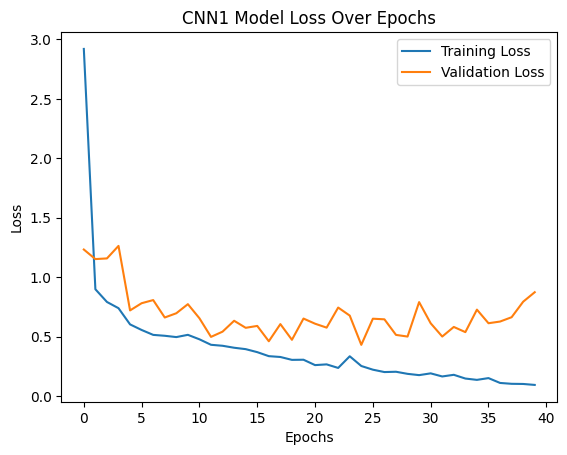

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


training_history = pd.read_csv('training_history_cnn1.csv')

plt.plot(training_history['loss'], label='Training Loss')
plt.plot(training_history['val_loss'], label='Validation Loss')
plt.title('CNN1 Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


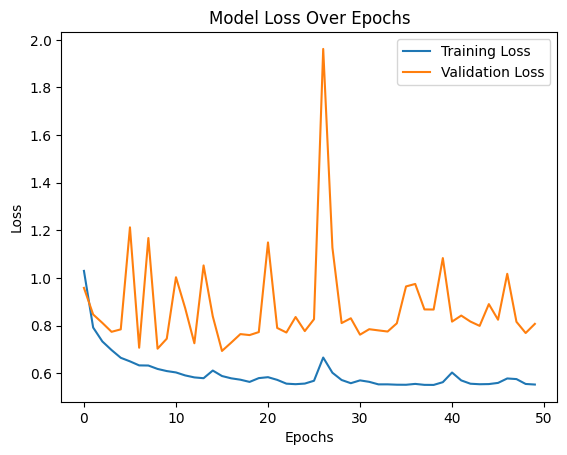

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


training_history = pd.read_csv('training_history_cnn2.csv')

plt.plot(training_history['loss'], label='Training Loss')
plt.plot(training_history['val_loss'], label='Validation Loss')
plt.title('CNN2 Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



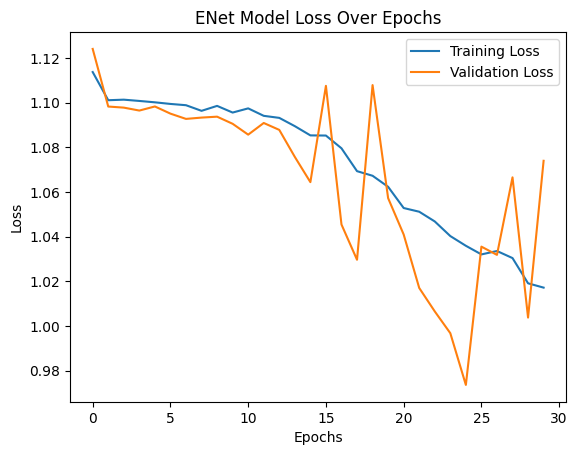

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


training_history = pd.read_csv('training_history_enet.csv')

plt.plot(training_history['loss'], label='Training Loss')
plt.plot(training_history['val_loss'], label='Validation Loss')
plt.title('ENet Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


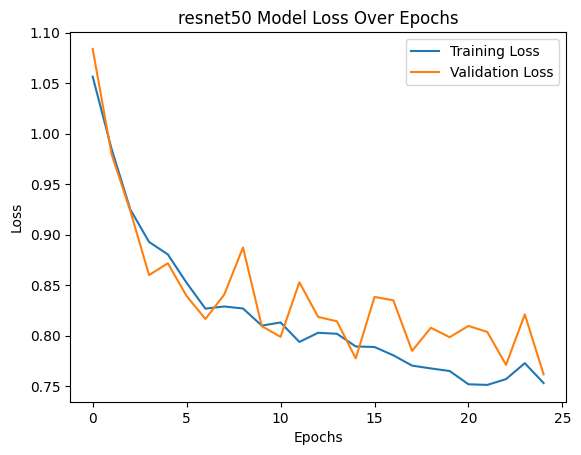

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


training_history = pd.read_csv('training_history_resnet50.csv')

plt.plot(training_history['loss'], label='Training Loss')
plt.plot(training_history['val_loss'], label='Validation Loss')
plt.title('resnet50 Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


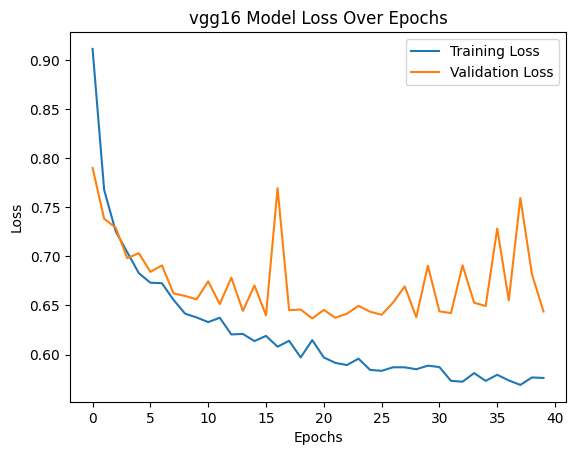

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


training_history = pd.read_csv('training_history_vgg16.csv')

plt.plot(training_history['loss'], label='Training Loss')
plt.plot(training_history['val_loss'], label='Validation Loss')
plt.title('vgg16 Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


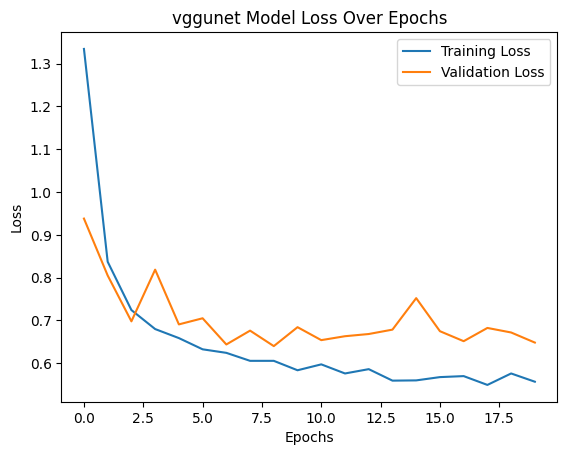

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


training_history = pd.read_csv('training_history_vggunet.csv')

plt.plot(training_history['loss'], label='Training Loss')
plt.plot(training_history['val_loss'], label='Validation Loss')
plt.title('vggunet Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Performance metrics
In the first cell, we tabularized the performance metrics of our 6 models. The two CNN models we built from scratch show best result in terms of test accuracy. The second CNN model and transfer models perform better at test loss.

Overall, the second CNN model displayed good performance over both loss and accuracy.

### Convergance
* CNN1: took about 25 epochs to converge, after that it displayed signs of overfitting.
* CNN2: has converged after 50 epochs, maybe need more ephochs to converge and fit, but due to time and computational resource limit, we decide to stop at 50 epochs.
* ENet: ENet doesn't perform well here possibly due to its large scale. The training loss is still decreasing after 30 epochs so it need a lot more epochs to converge, but due to time and computational resource limit, we decide to stop at 30 epochs.
* ResNet50: took 25 epochs to converge, no sign of overfitting
* vgg16: took 20 epochs to converge, showed sign of overfitting after 30 epochs
* vgg-unet: took about 10 epochs to converge, showed sign of mild overfitting toward 20 epochs.

In conclusion, ResNet50 converges fast due to its flexible and small network architecture, followed by vgg16, CNN1. For the same reason, ENet converges most slowly.

Additionally, adding UNet to VGG improved its convergence rate significantly. This may be because of the efficient upsampling technique that UNet applies.

# **STEP 9: Conclusions**

## Conclusion on this project
1. We performed data augmentation on giving image set and preprocessed it to fit the input size of CNN. We then splitted the augmented dataset into train and validation set.
2. We performed edge detection before diving into CNN to get some preliminary insights on the data. The result showed some degree of pattern within each outcome category.
3. We built 2 CNN models from scratch, each has achieved accuracy about 80% on validation set.
4. We built 3 transfer learning models based on EfficientNetB3, ResNet50 and VGG16. ResNet50 converges the fastest and VGG16 has best performance of the 3.
5. We built another transfer model based on VGG-Unet, which converges very fast and has good performance.


## Insights from this project
1. Data augmentation can greatly increase training set size of images, but at the cost of high demand of GPU resource and computational power. We should augment datasets if we have strong computational power for example in enterprises and research labs, but tread carefully with data augmentation in personal preojects,
2. When building CNN from scratch, we can evaluate preliminary model and adjust its structure based on performance metric. For example, if the model is converging too slow, try deleting some dropout layers or decrease the rate.
3. When choosing transfer model, consider the relative complexity of the model to the task.

## Something to improve
1. Put more efforts on the fine-tuning of transfer models
